## Classification

In [1]:
import torch
import torch.utils.data
import torch.utils.data as data_utils
import torchvision.transforms as T
import pickle as pkl
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
from importlib import import_module
import shutil
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from torch.nn.utils.rnn import pad_sequence
import pickle as pkl
import cv2
import logging
import math
import functools
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter as P

class CustomDataset(data_utils.Dataset):
 
    def __init__(self,aug = False):
        with open("/kaggle/input/dataset-cs114/dataset (1).pkl", "rb") as f:
            data = pkl.load(f)

        self.word_data = data["data"]
        self.idx_to_id = {i: w_id for i, w_id in enumerate(self.word_data.keys())}
     
        if aug:
            self.transform = T.Compose([
                    T.Resize((128,128)),
                    T.RandomChoice([
                        T.ColorJitter(0.2, 0.2),
                        T.GaussianBlur(3),
                        T.RandomAdjustSharpness(2),
                   

                    ]),
                     T.ToTensor() ,
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  
                ])
        else:
            self.transform = T.Compose([
                    T.Resize((128,128)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])   
                    
                ])
        
         
    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        item = {}
        w_id = self.idx_to_id[idx]

        # Get image and label
        lab, img = self.word_data[w_id]
      
        img =   self.transform(img)

        item["img"] = img.float()
        item["label"] = torch.tensor(lab)


        return item

dataset = CustomDataset()
aug_dataset = CustomDataset(aug = True)
 
 


In [2]:
from torch.utils.data import ConcatDataset
final_dataset = ConcatDataset([aug_dataset, dataset])

In [3]:
print(len(final_dataset))

12296


In [4]:
from torch.utils.data import random_split
 
total_size = len(final_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_set, test_set = random_split(final_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

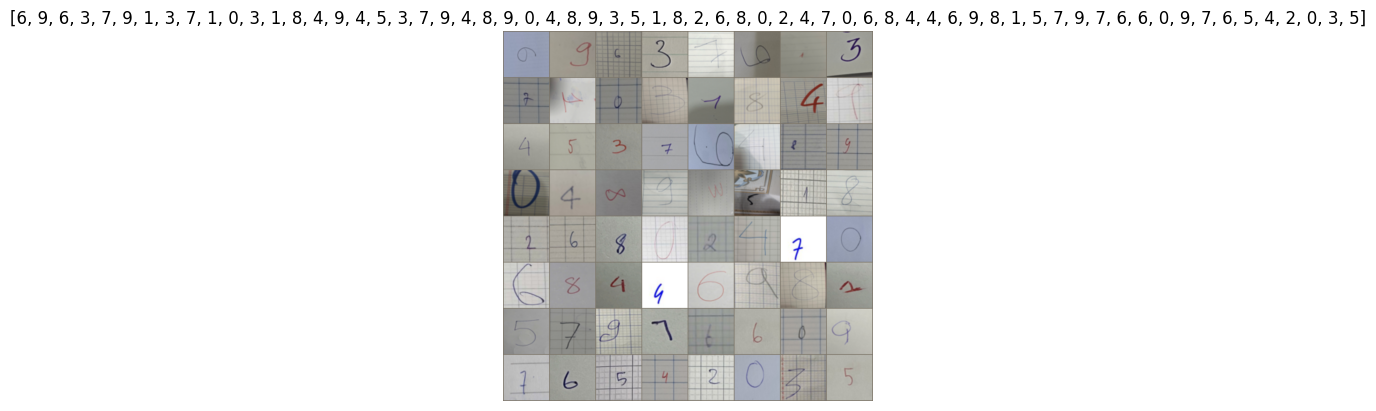

In [5]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
 
def imshow(inp, title=None):   
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
 
batch = next(iter(train_loader))
inputs = batch["img"]
classes = batch["label"]
 
out = torchvision.utils.make_grid(inputs)

 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
out = unnormalize(out.clone(), mean, std)
 
imshow(out, title=[int(x) for x in classes])

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [7]:
device = "cuda"
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [8]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_loss = 999
        cnt_stop = 0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch in tqdm(train_loader):
                    inputs = batch["img"].to(device)
                    labels = batch["label"].to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item()
     
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(train_loader)
                if epoch_loss < best_loss:
                    torch.save(model.state_dict(), best_model_params_path)
                    best_loss = epoch_loss
                    cnt_stop = 0
                else:
                    cnt_stop += 1
                if cnt_stop>=5:
                    return model

                print(f'{phase} Loss: {epoch_loss:.4f}')

              
    return model

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


100%|██████████| 154/154 [00:14<00:00, 10.78it/s]


train Loss: 1.9968
Epoch 1/49
----------


100%|██████████| 154/154 [00:12<00:00, 11.87it/s]


train Loss: 1.5682
Epoch 2/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.52it/s]


train Loss: 1.4144
Epoch 3/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.74it/s]


train Loss: 1.3294
Epoch 4/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.05it/s]


train Loss: 1.2740
Epoch 5/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.22it/s]


train Loss: 1.2354
Epoch 6/49
----------


100%|██████████| 154/154 [00:12<00:00, 11.86it/s]


train Loss: 1.1985
Epoch 7/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.39it/s]


train Loss: 1.1634
Epoch 8/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.43it/s]


train Loss: 1.1565
Epoch 9/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.11it/s]


train Loss: 1.1562
Epoch 10/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.26it/s]


train Loss: 1.1558
Epoch 11/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.32it/s]


train Loss: 1.1539
Epoch 12/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.36it/s]


train Loss: 1.1541
Epoch 13/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.37it/s]


train Loss: 1.1451
Epoch 14/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.33it/s]


train Loss: 1.1446
Epoch 15/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.46it/s]


train Loss: 1.1420
Epoch 16/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.16it/s]


train Loss: 1.1502
Epoch 17/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.09it/s]


train Loss: 1.1427
Epoch 18/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.25it/s]


train Loss: 1.1511
Epoch 19/49
----------


100%|██████████| 154/154 [00:13<00:00, 11.80it/s]


train Loss: 1.1441
Epoch 20/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.14it/s]


train Loss: 1.1419
Epoch 21/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.16it/s]


train Loss: 1.1452
Epoch 22/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.20it/s]


train Loss: 1.1444
Epoch 23/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.07it/s]


train Loss: 1.1457
Epoch 24/49
----------


100%|██████████| 154/154 [00:13<00:00, 11.52it/s]


train Loss: 1.1415
Epoch 25/49
----------


100%|██████████| 154/154 [00:12<00:00, 11.96it/s]


train Loss: 1.1404
Epoch 26/49
----------


100%|██████████| 154/154 [00:13<00:00, 11.81it/s]


train Loss: 1.1469
Epoch 27/49
----------


100%|██████████| 154/154 [00:12<00:00, 11.91it/s]


train Loss: 1.1387
Epoch 28/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.24it/s]


train Loss: 1.1414
Epoch 29/49
----------


100%|██████████| 154/154 [00:13<00:00, 11.56it/s]


train Loss: 1.1464
Epoch 30/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.11it/s]


train Loss: 1.1393
Epoch 31/49
----------


100%|██████████| 154/154 [00:12<00:00, 12.11it/s]


train Loss: 1.1479
Epoch 32/49
----------


100%|██████████| 154/154 [00:12<00:00, 11.96it/s]


In [11]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["img"].to(device)
        labels = batch["label"].to(device)
        
        outputs =model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 39/39 [00:03<00:00, 11.52it/s]


In [12]:
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))

Test Accuracy: 0.6036585365853658
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       225
           1       0.59      0.68      0.63       241
           2       0.57      0.51      0.54       259
           3       0.53      0.52      0.52       232
           4       0.56      0.53      0.54       250
           5       0.67      0.60      0.63       247
           6       0.68      0.60      0.64       258
           7       0.57      0.58      0.58       258
           8       0.62      0.67      0.64       251
           9       0.58      0.56      0.57       239

    accuracy                           0.60      2460
   macro avg       0.60      0.61      0.60      2460
weighted avg       0.60      0.60      0.60      2460

